# Player Direction Prediction with Pitch Coordinates
## ITU BLG 506E/521E - Computer Vision & AI
### Author: Ömer Faruk Coşar

This notebook trains a model to predict player body orientation using:
- **Image features** from the player crop (CNN backbone)
- **Pitch coordinates** from bounding box position (MLP encoder)

The model outputs direction as a **unit vector** (cos θ, sin θ) to avoid angle discontinuity issues.

## 1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Imports and Setup

In [2]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision imports
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Standard imports
import numpy as np
import json
import math
from pathlib import Path
from collections import defaultdict
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6


## 3. Configuration

**⚠️ IMPORTANT: Update the paths below to match your Google Drive structure!**

In [3]:
# Configuration - Optimized for 3,700 samples
CONFIG = {
    # Data paths
    'dataset_root': '/content/drive/MyDrive/player_direction_dataset',
    'save_dir': '/content/drive/MyDrive/player_direction_checkpoints_4059_optimized',

    # Data loading
    'batch_size': 48,       # ← Larger batch (more stable gradients)
    'num_workers': 0,
    'image_size': 224,

    # Model
    'backbone': 'resnet50',
    'dropout': 0.5,         # ← Reduced (less aggressive with more data)
    'freeze_backbone': False,

    # Training
    'epochs': 250,          # ← More epochs (model needs time)
    'lr': 1e-4,          # ← Slightly higher (faster convergence)
    'weight_decay': 5e-6,   # ← Less regularization (more data = less needed)
    'patience': 40,         # ← Very patient (wait for convergence)

    # Checkpointing
    'save_best': True
}

## 4. Dataset Class with Pitch Coordinates

In [4]:
## 8. Load Data

class PlayerDirectionDataset(Dataset):
    """
    Player direction dataset with pitch coordinates

    Returns:
        image: [3, H, W] - Normalized player crop
        bbox_pitch: [6] - Pitch coordinates [x_left, y_left, x_right, y_right, x_mid, y_mid]
        direction: [2] - Unit vector [cos(θ), sin(θ)]
        angle_deg: float - Original angle in degrees (for evaluation)
    """

    def __init__(self, root_dir, split='train', transform=None, augment=True):
        self.root_dir = Path(root_dir) / split
        self.split = split
        self.transform = transform
        self.augment = augment and (split == 'train')

        # Load labels
        labels_path = self.root_dir / 'labels.json'
        if not labels_path.exists():
            raise FileNotFoundError(f"Labels not found: {labels_path}")

        with open(labels_path) as f:
            all_labels = json.load(f)

        # Filter out samples without bbox_pitch data
        self.labels = []
        filtered_count = 0

        for label in all_labels:
            bbox_pitch = label.get('bbox_pitch')
            # Check if bbox_pitch exists and has valid data
            if bbox_pitch and len(bbox_pitch) > 0:
                # Verify it has the required keys
                required_keys = ['x_bottom_left', 'y_bottom_left', 'x_bottom_right',
                               'y_bottom_right', 'x_bottom_middle', 'y_bottom_middle']
                if all(key in bbox_pitch for key in required_keys):
                    self.labels.append(label)
                else:
                    filtered_count += 1
            else:
                filtered_count += 1

        print(f"✓ Loaded {len(self.labels)} samples ({split})")
        if filtered_count > 0:
            print(f"  ⚠️  Filtered out {filtered_count} samples without bbox_pitch data")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]

        # Load image
        img_path = self.root_dir / 'images' / label['filename']
        img = Image.open(img_path).convert('RGB')

        # Get angle
        angle = label['direction_degree']

        # Get bbox_pitch coordinates (guaranteed to exist now)
        bbox_pitch = label['bbox_pitch']
        bbox_tensor = torch.tensor([
            bbox_pitch['x_bottom_left'],
            bbox_pitch['y_bottom_left'],
            bbox_pitch['x_bottom_right'],
            bbox_pitch['y_bottom_right'],
            bbox_pitch['x_bottom_middle'],
            bbox_pitch['y_bottom_middle']
        ], dtype=torch.float32)

        # Geometric augmentation
        if self.augment:
            # Horizontal flip: mirror angle and x-coordinates
            if np.random.random() > 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                angle = (180 - angle) % 360
                # Flip x-coordinates in bbox_pitch
                if bbox_pitch:
                    bbox_tensor[0] = -bbox_tensor[0]  # x_left
                    bbox_tensor[2] = -bbox_tensor[2]  # x_right
                    bbox_tensor[4] = -bbox_tensor[4]  # x_middle

            # Small rotation - CHANGE THIS PART
            if np.random.random() > 0.7:
                rotation = np.random.uniform(-10, 10)  # ← Back to ±10°
                img = img.rotate(rotation, fillcolor=(0, 0, 0))
                angle = (angle - rotation) % 360

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        # Convert angle to unit vector
        angle_rad = math.radians(angle)
        direction = torch.tensor([math.cos(angle_rad), math.sin(angle_rad)],
                                dtype=torch.float32)

        return img, bbox_tensor, direction, angle


def get_transforms(split='train', image_size=224):
    """Get transforms for split"""
    if split == 'train':
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
        ])


def create_dataloaders(dataset_root, batch_size=16, num_workers=2, image_size=224):
    """Create train/valid/test dataloaders"""
    dataloaders = {}

    for split in ['train', 'valid', 'test']:
        try:
            dataset = PlayerDirectionDataset(
                root_dir=dataset_root,
                split=split,
                transform=get_transforms(split, image_size),
                augment=(split == 'train')
            )

            dataloaders[split] = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=(split == 'train'),
                num_workers=num_workers,
                pin_memory=True
            )
        except Exception as e:
            print(f"Warning: Could not load {split} split: {e}")

    return dataloaders


# Create dataloaders
print("Creating dataloaders...")
dataloaders = create_dataloaders(
    dataset_root=CONFIG['dataset_root'],
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    image_size=CONFIG['image_size']
)

# Check if dataloaders were created
if not dataloaders:
    raise RuntimeError("No dataloaders created! Check your dataset path.")

# Print dataset sizes
print("\nDataset sizes:")
for split, loader in dataloaders.items():
    print(f"  {split}: {len(loader.dataset)} samples ({len(loader)} batches)")

# Test loading a batch
print("\nTest batch loading:")
images, bbox_pitch, directions, angles = next(iter(dataloaders['train']))
print(f"  Images shape: {images.shape}")
print(f"  BBox pitch shape: {bbox_pitch.shape}")
print(f"  Directions shape: {directions.shape}")
print(f"  Sample angles: {angles[:5].numpy()}")
print(f"  Sample bbox_pitch (first 3 samples):")
for i in range(min(3, len(bbox_pitch))):
    print(f"    Sample {i}: {bbox_pitch[i].numpy()}")

Creating dataloaders...
✓ Loaded 2995 samples (train)
  ⚠️  Filtered out 49 samples without bbox_pitch data
✓ Loaded 606 samples (valid)
  ⚠️  Filtered out 2 samples without bbox_pitch data
✓ Loaded 403 samples (test)
  ⚠️  Filtered out 4 samples without bbox_pitch data

Dataset sizes:
  train: 2995 samples (63 batches)
  valid: 606 samples (13 batches)
  test: 403 samples (9 batches)

Test batch loading:
  Images shape: torch.Size([48, 3, 224, 224])
  BBox pitch shape: torch.Size([48, 6])
  Directions shape: torch.Size([48, 2])
  Sample angles: [332.63178957  67.10944834 235.97724903  74.17899351  77.94921512]
  Sample bbox_pitch (first 3 samples):
    Sample 0: [30.866655 14.370335 30.356997 13.877417 30.6116   14.12364 ]
    Sample 1: [  3.3688366 -20.87585     2.484199  -20.909616    2.9264119 -20.892876 ]
    Sample 2: [20.93052    0.5867156 19.971367   0.3608784 20.451115   0.4740412]


## 5. Model Architecture

In [5]:
class PlayerDirectionModel(nn.Module):
    """
    Multi-modal model combining image and pitch position

    Architecture:
    1. CNN backbone (ResNet) for image features
    2. MLP for pitch coordinate features
    3. Fusion layer combining both
    4. Direction prediction head (unit vector output)
    """

    def __init__(self, backbone='resnet34', dropout=0.5, bbox_dim=6, freeze_backbone=False):
        super().__init__()

        # Image encoder (CNN backbone)
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=True)
            image_feat_dim = 512
        elif backbone == 'resnet34':
            resnet = models.resnet34(pretrained=True)
            image_feat_dim = 512
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=True)
            image_feat_dim = 2048
        elif backbone == 'resnet101':  # ← ADD THIS
            resnet = models.resnet101(pretrained=True)
            image_feat_dim = 2048
        else:
            raise ValueError(f"Unknown backbone: {backbone}")

        # Remove final FC layer
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

        # Bbox encoder (MLP for pitch coordinates)
        self.bbox_encoder = nn.Sequential(
            nn.Linear(bbox_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Fusion layer
        fusion_dim = image_feat_dim + 32
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Direction head (unit vector output)
        self.direction_head = nn.Linear(128, 2)

    def forward(self, image, bbox_pitch):
        """
        Args:
            image: [B, 3, H, W] - Player crop image
            bbox_pitch: [B, 6] - Pitch coordinates

        Returns:
            direction: [B, 2] - Unit vector (cos θ, sin θ)
        """
        # Encode image
        img_feat = self.image_encoder(image)  # [B, feat_dim, 1, 1]
        img_feat = img_feat.flatten(1)        # [B, feat_dim]

        # Encode bbox
        bbox_feat = self.bbox_encoder(bbox_pitch)  # [B, 32]

        # Fuse features
        combined = torch.cat([img_feat, bbox_feat], dim=1)
        fused = self.fusion(combined)

        # Predict direction
        direction = self.direction_head(fused)

        # Normalize to unit vector
        direction = F.normalize(direction, p=2, dim=1)

        return direction

## 6. Loss Function and Metrics

In [6]:
def cosine_similarity_loss(pred, target):
    """
    Cosine similarity loss for unit vectors
    Loss = 1 - cos(pred, target)

    Range: [0, 2]
    - 0 = perfect match (0° aligned)
    - 1 = perpendicular (90° error)
    - 2 = opposite (180° error)
    """
    return 1 - F.cosine_similarity(pred, target, dim=1).mean()


def angular_error(pred, target):
    """
    Calculate angular error in degrees

    Args:
        pred: [B, 2] - Predicted unit vectors
        target: [B, 2] - Target unit vectors

    Returns:
        error: Mean angular error in degrees
    """
    # Cosine similarity
    cos_sim = F.cosine_similarity(pred, target, dim=1)

    # Clamp to avoid numerical issues with arccos
    cos_sim = torch.clamp(cos_sim, -1.0, 1.0)

    # Angular error in radians
    error_rad = torch.acos(cos_sim)

    # Convert to degrees
    error_deg = torch.rad2deg(error_rad)

    return error_deg.mean().item()


def vector_to_angle(vector):
    """
    Convert unit vector to angle in degrees

    Args:
        vector: [..., 2] - Unit vectors [cos, sin]

    Returns:
        angles: [...] - Angles in degrees [0, 360)
    """
    angles_rad = torch.atan2(vector[..., 1], vector[..., 0])
    angles_deg = torch.rad2deg(angles_rad)
    angles_deg = (angles_deg + 360) % 360  # Ensure [0, 360)
    return angles_deg

## 7. Training Functions

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()

    total_loss = 0.0
    total_angular_error = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, bbox_pitch, directions, _ in pbar:
        # Move to device
        images = images.to(device)
        bbox_pitch = bbox_pitch.to(device)
        directions = directions.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred_directions = model(images, bbox_pitch)

        # Compute loss
        loss = criterion(pred_directions, directions)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        total_angular_error += angular_error(pred_directions, directions)
        num_batches += 1

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'angle_err': f"{angular_error(pred_directions, directions):.2f}°"
        })

    return total_loss / num_batches, total_angular_error / num_batches


def evaluate(model, dataloader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()

    total_loss = 0.0
    total_angular_error = 0.0
    num_batches = 0

    all_errors = []

    with torch.no_grad():
        for images, bbox_pitch, directions, _ in tqdm(dataloader, desc='Evaluating'):
            # Move to device
            images = images.to(device)
            bbox_pitch = bbox_pitch.to(device)
            directions = directions.to(device)

            # Forward pass
            pred_directions = model(images, bbox_pitch)

            # Compute loss
            loss = criterion(pred_directions, directions)

            # Metrics
            total_loss += loss.item()

            # Individual angular errors
            cos_sim = F.cosine_similarity(pred_directions, directions, dim=1)
            cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
            errors = torch.rad2deg(torch.acos(cos_sim))
            all_errors.extend(errors.cpu().numpy())

            total_angular_error += errors.mean().item()
            num_batches += 1

    return {
        'loss': total_loss / num_batches,
        'angular_error': total_angular_error / num_batches,
        'all_errors': np.array(all_errors)
    }

## 8. Load Data

In [8]:
# Create dataloaders
print("Creating dataloaders...")
dataloaders = create_dataloaders(
    dataset_root=CONFIG['dataset_root'],
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    image_size=CONFIG['image_size']
)

# Check if dataloaders were created
if not dataloaders:
    raise RuntimeError("No dataloaders created! Check your dataset path.")

# Print dataset sizes
print("\nDataset sizes:")
for split, loader in dataloaders.items():
    print(f"  {split}: {len(loader.dataset)} samples ({len(loader)} batches)")

# Test loading a batch
print("\nTest batch loading:")
images, bbox_pitch, directions, angles = next(iter(dataloaders['train']))
print(f"  Images shape: {images.shape}")
print(f"  BBox pitch shape: {bbox_pitch.shape}")
print(f"  Directions shape: {directions.shape}")
print(f"  Sample angles: {angles[:5].numpy()}")
print(f"  Sample bbox_pitch (first sample): {bbox_pitch[0].numpy()}")

Creating dataloaders...
✓ Loaded 2995 samples (train)
  ⚠️  Filtered out 49 samples without bbox_pitch data
✓ Loaded 606 samples (valid)
  ⚠️  Filtered out 2 samples without bbox_pitch data
✓ Loaded 403 samples (test)
  ⚠️  Filtered out 4 samples without bbox_pitch data

Dataset sizes:
  train: 2995 samples (63 batches)
  valid: 606 samples (13 batches)
  test: 403 samples (9 batches)

Test batch loading:
  Images shape: torch.Size([48, 3, 224, 224])
  BBox pitch shape: torch.Size([48, 6])
  Directions shape: torch.Size([48, 2])
  Sample angles: [ 66.03199873 137.45403167  84.84261032  56.87086817 138.75855569]
  Sample bbox_pitch (first sample): [11.747897   7.251775  12.562562   7.495833  12.155257   7.3738217]


## 9. Create Model

In [9]:
# Create model
print("Creating model...")
model = PlayerDirectionModel(
    backbone=CONFIG['backbone'],
    dropout=CONFIG['dropout'],
    freeze_backbone=CONFIG['freeze_backbone']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: {CONFIG['backbone']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    test_out = model(images.to(device), bbox_pitch.to(device))
    print(f"Output shape: {test_out.shape}")
    print(f"Output is normalized: {torch.allclose(torch.norm(test_out, dim=1), torch.ones(test_out.size(0)).to(device))}")
    print(f"Sample predictions (unit vectors): {test_out[:3].cpu().numpy()}")

Creating model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]



Model: resnet50
Total parameters: 24,076,450
Trainable parameters: 24,076,450

Testing forward pass...
Output shape: torch.Size([48, 2])
Output is normalized: True
Sample predictions (unit vectors): [[ 0.87389743  0.48611045]
 [ 0.98746663 -0.15782803]
 [-0.9494381  -0.31395444]]


## 10. Setup Training

In [10]:
## 10. Setup Training

# Loss function
criterion = cosine_similarity_loss

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("Training setup complete!")
print(f"  Optimizer: Adam (lr={CONFIG['lr']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print(f"  Loss: Cosine Similarity Loss")
print(f"  Checkpoints will be saved to: {CONFIG['save_dir']}")

Training setup complete!
  Optimizer: Adam (lr=0.0001, wd=5e-06)
  Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
  Loss: Cosine Similarity Loss
  Checkpoints will be saved to: /content/drive/MyDrive/player_direction_checkpoints_4059_optimized


## 11. Training Loop

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_angle_error': [],
    'valid_loss': [],
    'valid_angle_error': []
}

best_valid_loss = float('inf')
patience_counter = 0

# Ensure the save directory exists
Path(CONFIG['save_dir']).mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 70)

    # Train
    train_loss, train_angle_error = train_epoch(
        model, dataloaders['train'], criterion, optimizer, device
    )

    # Validate
    valid_metrics = evaluate(model, dataloaders['valid'], criterion, device)

    # Update scheduler
    scheduler.step(valid_metrics['loss'])

    # Save history
    history['train_loss'].append(train_loss)
    history['train_angle_error'].append(train_angle_error)
    history['valid_loss'].append(valid_metrics['loss'])
    history['valid_angle_error'].append(valid_metrics['angular_error'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Angle Error: {train_angle_error:.2f}°")
    print(f"  Valid Loss: {valid_metrics['loss']:.4f} | Angle Error: {valid_metrics['angular_error']:.2f}°")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if valid_metrics['loss'] < best_valid_loss:
        best_valid_loss = valid_metrics['loss']
        patience_counter = 0

        if CONFIG['save_best']:
            checkpoint_path = Path(CONFIG['save_dir']) / 'best_model.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_metrics['loss'],
                'valid_angle_error': valid_metrics['angular_error'],
                'config': CONFIG
            }, checkpoint_path)
            print(f"  ✓ Saved best model (val_loss: {best_valid_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{CONFIG['patience']}")

    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best validation loss: {best_valid_loss:.4f}")


STARTING TRAINING

Epoch 1/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.9947 | Angle Error: 89.65°
  Valid Loss: 0.9954 | Angle Error: 89.52°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.9954)

Epoch 2/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.9651 | Angle Error: 87.30°
  Valid Loss: 1.0011 | Angle Error: 90.13°
  LR: 0.000100
  Patience: 1/40

Epoch 3/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.9710 | Angle Error: 87.92°
  Valid Loss: 0.8985 | Angle Error: 82.40°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.8985)

Epoch 4/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.9232 | Angle Error: 84.55°
  Valid Loss: 0.8786 | Angle Error: 80.53°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.8786)

Epoch 5/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.8840 | Angle Error: 81.28°
  Valid Loss: 0.8910 | Angle Error: 82.17°
  LR: 0.000100
  Patience: 1/40

Epoch 6/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.8752 | Angle Error: 80.52°
  Valid Loss: 0.8491 | Angle Error: 78.99°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.8491)

Epoch 7/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.8527 | Angle Error: 79.25°
  Valid Loss: 0.8766 | Angle Error: 81.28°
  LR: 0.000100
  Patience: 1/40

Epoch 8/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.8339 | Angle Error: 77.81°
  Valid Loss: 0.8812 | Angle Error: 81.44°
  LR: 0.000100
  Patience: 2/40

Epoch 9/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.8018 | Angle Error: 75.35°
  Valid Loss: 0.8385 | Angle Error: 77.77°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.8385)

Epoch 10/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.7489 | Angle Error: 71.59°
  Valid Loss: 0.7733 | Angle Error: 73.23°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.7733)

Epoch 11/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.6559 | Angle Error: 64.68°
  Valid Loss: 0.6401 | Angle Error: 63.49°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.6401)

Epoch 12/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.6174 | Angle Error: 61.86°
  Valid Loss: 0.6130 | Angle Error: 61.03°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.6130)

Epoch 13/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.5742 | Angle Error: 58.56°
  Valid Loss: 0.4858 | Angle Error: 51.88°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4858)

Epoch 14/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.5394 | Angle Error: 56.12°
  Valid Loss: 0.5724 | Angle Error: 57.82°
  LR: 0.000100
  Patience: 1/40

Epoch 15/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.5559 | Angle Error: 57.09°
  Valid Loss: 0.4927 | Angle Error: 51.78°
  LR: 0.000100
  Patience: 2/40

Epoch 16/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.5256 | Angle Error: 55.06°
  Valid Loss: 0.4112 | Angle Error: 46.17°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4112)

Epoch 17/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.4686 | Angle Error: 50.53°
  Valid Loss: 0.5229 | Angle Error: 54.67°
  LR: 0.000100
  Patience: 1/40

Epoch 18/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.4270 | Angle Error: 47.46°
  Valid Loss: 0.4326 | Angle Error: 47.86°
  LR: 0.000100
  Patience: 2/40

Epoch 19/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19 Summary:
  Train Loss: 0.3993 | Angle Error: 45.09°
  Valid Loss: 0.5545 | Angle Error: 56.75°
  LR: 0.000100
  Patience: 3/40

Epoch 20/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20 Summary:
  Train Loss: 0.3940 | Angle Error: 44.50°
  Valid Loss: 0.6199 | Angle Error: 61.66°
  LR: 0.000100
  Patience: 4/40

Epoch 21/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 21 Summary:
  Train Loss: 0.5380 | Angle Error: 55.84°
  Valid Loss: 0.4995 | Angle Error: 52.58°
  LR: 0.000100
  Patience: 5/40

Epoch 22/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 22 Summary:
  Train Loss: 0.4272 | Angle Error: 47.28°
  Valid Loss: 0.4834 | Angle Error: 51.33°
  LR: 0.000050
  Patience: 6/40

Epoch 23/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 23 Summary:
  Train Loss: 0.3907 | Angle Error: 44.43°
  Valid Loss: 0.4181 | Angle Error: 46.14°
  LR: 0.000050
  Patience: 7/40

Epoch 24/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 24 Summary:
  Train Loss: 0.3446 | Angle Error: 40.85°
  Valid Loss: 0.3994 | Angle Error: 44.93°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3994)

Epoch 25/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 25 Summary:
  Train Loss: 0.3411 | Angle Error: 40.37°
  Valid Loss: 0.3811 | Angle Error: 43.38°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3811)

Epoch 26/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 26 Summary:
  Train Loss: 0.2982 | Angle Error: 37.06°
  Valid Loss: 0.3516 | Angle Error: 40.99°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3516)

Epoch 27/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 27 Summary:
  Train Loss: 0.2682 | Angle Error: 34.69°
  Valid Loss: 0.3529 | Angle Error: 41.00°
  LR: 0.000050
  Patience: 1/40

Epoch 28/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 28 Summary:
  Train Loss: 0.2632 | Angle Error: 34.19°
  Valid Loss: 0.2919 | Angle Error: 36.28°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.2919)

Epoch 29/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 29 Summary:
  Train Loss: 0.2522 | Angle Error: 33.32°
  Valid Loss: 0.3186 | Angle Error: 38.40°
  LR: 0.000050
  Patience: 1/40

Epoch 30/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 30 Summary:
  Train Loss: 0.2722 | Angle Error: 34.85°
  Valid Loss: 0.3146 | Angle Error: 37.64°
  LR: 0.000050
  Patience: 2/40

Epoch 31/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 31 Summary:
  Train Loss: 0.2698 | Angle Error: 34.63°
  Valid Loss: 0.3632 | Angle Error: 41.81°
  LR: 0.000050
  Patience: 3/40

Epoch 32/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 32 Summary:
  Train Loss: 0.2666 | Angle Error: 34.31°
  Valid Loss: 0.3003 | Angle Error: 36.92°
  LR: 0.000050
  Patience: 4/40

Epoch 33/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 33 Summary:
  Train Loss: 0.2314 | Angle Error: 31.51°
  Valid Loss: 0.3077 | Angle Error: 36.88°
  LR: 0.000050
  Patience: 5/40

Epoch 34/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 34 Summary:
  Train Loss: 0.2113 | Angle Error: 29.65°
  Valid Loss: 0.3365 | Angle Error: 39.14°
  LR: 0.000025
  Patience: 6/40

Epoch 35/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 35 Summary:
  Train Loss: 0.2189 | Angle Error: 30.34°
  Valid Loss: 0.2860 | Angle Error: 35.09°
  LR: 0.000025
  ✓ Saved best model (val_loss: 0.2860)

Epoch 36/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 36 Summary:
  Train Loss: 0.2055 | Angle Error: 29.12°
  Valid Loss: 0.2862 | Angle Error: 34.90°
  LR: 0.000025
  Patience: 1/40

Epoch 37/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 37 Summary:
  Train Loss: 0.1904 | Angle Error: 27.89°
  Valid Loss: 0.2733 | Angle Error: 33.66°
  LR: 0.000025
  ✓ Saved best model (val_loss: 0.2733)

Epoch 38/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 38 Summary:
  Train Loss: 0.1867 | Angle Error: 27.67°
  Valid Loss: 0.2496 | Angle Error: 31.78°
  LR: 0.000025
  ✓ Saved best model (val_loss: 0.2496)

Epoch 39/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 39 Summary:
  Train Loss: 0.1838 | Angle Error: 27.16°
  Valid Loss: 0.2731 | Angle Error: 33.75°
  LR: 0.000025
  Patience: 1/40

Epoch 40/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 40 Summary:
  Train Loss: 0.1785 | Angle Error: 26.61°
  Valid Loss: 0.2787 | Angle Error: 33.77°
  LR: 0.000025
  Patience: 2/40

Epoch 41/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 41 Summary:
  Train Loss: 0.1672 | Angle Error: 25.67°
  Valid Loss: 0.2833 | Angle Error: 34.36°
  LR: 0.000025
  Patience: 3/40

Epoch 42/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 42 Summary:
  Train Loss: 0.1866 | Angle Error: 27.26°
  Valid Loss: 0.3056 | Angle Error: 35.52°
  LR: 0.000025
  Patience: 4/40

Epoch 43/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 43 Summary:
  Train Loss: 0.1629 | Angle Error: 25.26°
  Valid Loss: 0.2769 | Angle Error: 33.46°
  LR: 0.000025
  Patience: 5/40

Epoch 44/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 44 Summary:
  Train Loss: 0.1781 | Angle Error: 26.64°
  Valid Loss: 0.2923 | Angle Error: 34.77°
  LR: 0.000013
  Patience: 6/40

Epoch 45/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 45 Summary:
  Train Loss: 0.1820 | Angle Error: 26.92°
  Valid Loss: 0.2676 | Angle Error: 32.79°
  LR: 0.000013
  Patience: 7/40

Epoch 46/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 46 Summary:
  Train Loss: 0.1589 | Angle Error: 24.93°
  Valid Loss: 0.2713 | Angle Error: 33.28°
  LR: 0.000013
  Patience: 8/40

Epoch 47/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 47 Summary:
  Train Loss: 0.1572 | Angle Error: 24.93°
  Valid Loss: 0.2870 | Angle Error: 34.61°
  LR: 0.000013
  Patience: 9/40

Epoch 48/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 48 Summary:
  Train Loss: 0.1729 | Angle Error: 26.15°
  Valid Loss: 0.2449 | Angle Error: 31.25°
  LR: 0.000013
  ✓ Saved best model (val_loss: 0.2449)

Epoch 49/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 49 Summary:
  Train Loss: 0.1575 | Angle Error: 24.78°
  Valid Loss: 0.2504 | Angle Error: 31.79°
  LR: 0.000013
  Patience: 1/40

Epoch 50/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 50 Summary:
  Train Loss: 0.1468 | Angle Error: 23.79°
  Valid Loss: 0.2582 | Angle Error: 32.10°
  LR: 0.000013
  Patience: 2/40

Epoch 51/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 51 Summary:
  Train Loss: 0.1496 | Angle Error: 24.26°
  Valid Loss: 0.2766 | Angle Error: 33.94°
  LR: 0.000013
  Patience: 3/40

Epoch 52/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 52 Summary:
  Train Loss: 0.1483 | Angle Error: 24.13°
  Valid Loss: 0.2530 | Angle Error: 31.79°
  LR: 0.000013
  Patience: 4/40

Epoch 53/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 53 Summary:
  Train Loss: 0.1366 | Angle Error: 23.08°
  Valid Loss: 0.2384 | Angle Error: 30.66°
  LR: 0.000013
  ✓ Saved best model (val_loss: 0.2384)

Epoch 54/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 54 Summary:
  Train Loss: 0.1488 | Angle Error: 23.77°
  Valid Loss: 0.2685 | Angle Error: 33.04°
  LR: 0.000013
  Patience: 1/40

Epoch 55/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 55 Summary:
  Train Loss: 0.1666 | Angle Error: 25.36°
  Valid Loss: 0.2586 | Angle Error: 32.31°
  LR: 0.000013
  Patience: 2/40

Epoch 56/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 56 Summary:
  Train Loss: 0.1523 | Angle Error: 24.52°
  Valid Loss: 0.2077 | Angle Error: 28.46°
  LR: 0.000013
  ✓ Saved best model (val_loss: 0.2077)

Epoch 57/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 57 Summary:
  Train Loss: 0.1419 | Angle Error: 23.23°
  Valid Loss: 0.2207 | Angle Error: 29.22°
  LR: 0.000013
  Patience: 1/40

Epoch 58/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 58 Summary:
  Train Loss: 0.1382 | Angle Error: 23.04°
  Valid Loss: 0.2127 | Angle Error: 28.61°
  LR: 0.000013
  Patience: 2/40

Epoch 59/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 59 Summary:
  Train Loss: 0.1379 | Angle Error: 23.17°
  Valid Loss: 0.2377 | Angle Error: 30.66°
  LR: 0.000013
  Patience: 3/40

Epoch 60/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 60 Summary:
  Train Loss: 0.1427 | Angle Error: 23.51°
  Valid Loss: 0.2301 | Angle Error: 29.80°
  LR: 0.000013
  Patience: 4/40

Epoch 61/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 61 Summary:
  Train Loss: 0.1305 | Angle Error: 22.45°
  Valid Loss: 0.2169 | Angle Error: 28.88°
  LR: 0.000013
  Patience: 5/40

Epoch 62/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 62 Summary:
  Train Loss: 0.1219 | Angle Error: 21.62°
  Valid Loss: 0.2289 | Angle Error: 29.77°
  LR: 0.000006
  Patience: 6/40

Epoch 63/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 63 Summary:
  Train Loss: 0.1247 | Angle Error: 22.01°
  Valid Loss: 0.2285 | Angle Error: 29.77°
  LR: 0.000006
  Patience: 7/40

Epoch 64/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 64 Summary:
  Train Loss: 0.1189 | Angle Error: 21.58°
  Valid Loss: 0.2255 | Angle Error: 29.43°
  LR: 0.000006
  Patience: 8/40

Epoch 65/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 65 Summary:
  Train Loss: 0.1212 | Angle Error: 21.48°
  Valid Loss: 0.2255 | Angle Error: 29.54°
  LR: 0.000006
  Patience: 9/40

Epoch 66/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 66 Summary:
  Train Loss: 0.1189 | Angle Error: 21.39°
  Valid Loss: 0.2256 | Angle Error: 29.46°
  LR: 0.000006
  Patience: 10/40

Epoch 67/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 67 Summary:
  Train Loss: 0.1155 | Angle Error: 20.81°
  Valid Loss: 0.2272 | Angle Error: 29.60°
  LR: 0.000006
  Patience: 11/40

Epoch 68/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 68 Summary:
  Train Loss: 0.1194 | Angle Error: 21.50°
  Valid Loss: 0.2240 | Angle Error: 29.33°
  LR: 0.000003
  Patience: 12/40

Epoch 69/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 69 Summary:
  Train Loss: 0.1099 | Angle Error: 20.44°
  Valid Loss: 0.2272 | Angle Error: 29.56°
  LR: 0.000003
  Patience: 13/40

Epoch 70/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 70 Summary:
  Train Loss: 0.1107 | Angle Error: 20.66°
  Valid Loss: 0.2159 | Angle Error: 28.67°
  LR: 0.000003
  Patience: 14/40

Epoch 71/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 71 Summary:
  Train Loss: 0.1086 | Angle Error: 20.47°
  Valid Loss: 0.2210 | Angle Error: 29.19°
  LR: 0.000003
  Patience: 15/40

Epoch 72/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 72 Summary:
  Train Loss: 0.1233 | Angle Error: 21.55°
  Valid Loss: 0.2232 | Angle Error: 29.43°
  LR: 0.000003
  Patience: 16/40

Epoch 73/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 73 Summary:
  Train Loss: 0.1099 | Angle Error: 20.46°
  Valid Loss: 0.2206 | Angle Error: 29.22°
  LR: 0.000003
  Patience: 17/40

Epoch 74/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 74 Summary:
  Train Loss: 0.1097 | Angle Error: 20.39°
  Valid Loss: 0.2124 | Angle Error: 28.39°
  LR: 0.000002
  Patience: 18/40

Epoch 75/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 75 Summary:
  Train Loss: 0.1172 | Angle Error: 21.11°
  Valid Loss: 0.2072 | Angle Error: 28.21°
  LR: 0.000002
  ✓ Saved best model (val_loss: 0.2072)

Epoch 76/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 76 Summary:
  Train Loss: 0.1094 | Angle Error: 20.31°
  Valid Loss: 0.2187 | Angle Error: 29.06°
  LR: 0.000002
  Patience: 1/40

Epoch 77/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 77 Summary:
  Train Loss: 0.1127 | Angle Error: 20.74°
  Valid Loss: 0.2077 | Angle Error: 28.11°
  LR: 0.000002
  Patience: 2/40

Epoch 78/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 78 Summary:
  Train Loss: 0.1095 | Angle Error: 20.52°
  Valid Loss: 0.2093 | Angle Error: 28.12°
  LR: 0.000002
  Patience: 3/40

Epoch 79/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 79 Summary:
  Train Loss: 0.1102 | Angle Error: 20.56°
  Valid Loss: 0.2098 | Angle Error: 28.28°
  LR: 0.000002
  Patience: 4/40

Epoch 80/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 80 Summary:
  Train Loss: 0.1125 | Angle Error: 20.73°
  Valid Loss: 0.2121 | Angle Error: 28.45°
  LR: 0.000002
  Patience: 5/40

Epoch 81/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 81 Summary:
  Train Loss: 0.1173 | Angle Error: 21.07°
  Valid Loss: 0.2143 | Angle Error: 28.59°
  LR: 0.000001
  Patience: 6/40

Epoch 82/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 82 Summary:
  Train Loss: 0.1062 | Angle Error: 20.07°
  Valid Loss: 0.2102 | Angle Error: 28.24°
  LR: 0.000001
  Patience: 7/40

Epoch 83/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 83 Summary:
  Train Loss: 0.1058 | Angle Error: 20.23°
  Valid Loss: 0.2176 | Angle Error: 28.94°
  LR: 0.000001
  Patience: 8/40

Epoch 84/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 84 Summary:
  Train Loss: 0.1054 | Angle Error: 20.04°
  Valid Loss: 0.2105 | Angle Error: 28.43°
  LR: 0.000001
  Patience: 9/40

Epoch 85/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 85 Summary:
  Train Loss: 0.1148 | Angle Error: 20.86°
  Valid Loss: 0.2095 | Angle Error: 28.33°
  LR: 0.000001
  Patience: 10/40

Epoch 86/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 86 Summary:
  Train Loss: 0.1111 | Angle Error: 20.72°
  Valid Loss: 0.2122 | Angle Error: 28.50°
  LR: 0.000001
  Patience: 11/40

Epoch 87/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 87 Summary:
  Train Loss: 0.1105 | Angle Error: 20.51°
  Valid Loss: 0.2126 | Angle Error: 28.48°
  LR: 0.000000
  Patience: 12/40

Epoch 88/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 88 Summary:
  Train Loss: 0.1047 | Angle Error: 19.97°
  Valid Loss: 0.2162 | Angle Error: 28.73°
  LR: 0.000000
  Patience: 13/40

Epoch 89/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 89 Summary:
  Train Loss: 0.1114 | Angle Error: 20.57°
  Valid Loss: 0.2143 | Angle Error: 28.73°
  LR: 0.000000
  Patience: 14/40

Epoch 90/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 90 Summary:
  Train Loss: 0.1094 | Angle Error: 20.23°
  Valid Loss: 0.2136 | Angle Error: 28.52°
  LR: 0.000000
  Patience: 15/40

Epoch 91/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 91 Summary:
  Train Loss: 0.1074 | Angle Error: 20.27°
  Valid Loss: 0.2156 | Angle Error: 28.74°
  LR: 0.000000
  Patience: 16/40

Epoch 92/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 92 Summary:
  Train Loss: 0.1072 | Angle Error: 20.24°
  Valid Loss: 0.2133 | Angle Error: 28.53°
  LR: 0.000000
  Patience: 17/40

Epoch 93/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 93 Summary:
  Train Loss: 0.1037 | Angle Error: 19.94°
  Valid Loss: 0.2127 | Angle Error: 28.43°
  LR: 0.000000
  Patience: 18/40

Epoch 94/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 94 Summary:
  Train Loss: 0.1071 | Angle Error: 20.14°
  Valid Loss: 0.2138 | Angle Error: 28.62°
  LR: 0.000000
  Patience: 19/40

Epoch 95/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 95 Summary:
  Train Loss: 0.1128 | Angle Error: 20.71°
  Valid Loss: 0.2103 | Angle Error: 28.23°
  LR: 0.000000
  Patience: 20/40

Epoch 96/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 96 Summary:
  Train Loss: 0.1081 | Angle Error: 20.29°
  Valid Loss: 0.2133 | Angle Error: 28.55°
  LR: 0.000000
  Patience: 21/40

Epoch 97/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 97 Summary:
  Train Loss: 0.1077 | Angle Error: 20.42°
  Valid Loss: 0.2100 | Angle Error: 28.26°
  LR: 0.000000
  Patience: 22/40

Epoch 98/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 98 Summary:
  Train Loss: 0.1150 | Angle Error: 20.86°
  Valid Loss: 0.2157 | Angle Error: 28.66°
  LR: 0.000000
  Patience: 23/40

Epoch 99/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 99 Summary:
  Train Loss: 0.1119 | Angle Error: 20.60°
  Valid Loss: 0.2103 | Angle Error: 28.27°
  LR: 0.000000
  Patience: 24/40

Epoch 100/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 100 Summary:
  Train Loss: 0.1081 | Angle Error: 19.99°
  Valid Loss: 0.2140 | Angle Error: 28.56°
  LR: 0.000000
  Patience: 25/40

Epoch 101/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 101 Summary:
  Train Loss: 0.1107 | Angle Error: 20.27°
  Valid Loss: 0.2130 | Angle Error: 28.46°
  LR: 0.000000
  Patience: 26/40

Epoch 102/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 102 Summary:
  Train Loss: 0.1112 | Angle Error: 20.61°
  Valid Loss: 0.2116 | Angle Error: 28.31°
  LR: 0.000000
  Patience: 27/40

Epoch 103/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 103 Summary:
  Train Loss: 0.1138 | Angle Error: 20.87°
  Valid Loss: 0.2171 | Angle Error: 28.72°
  LR: 0.000000
  Patience: 28/40

Epoch 104/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 104 Summary:
  Train Loss: 0.1078 | Angle Error: 20.25°
  Valid Loss: 0.2129 | Angle Error: 28.50°
  LR: 0.000000
  Patience: 29/40

Epoch 105/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 105 Summary:
  Train Loss: 0.1090 | Angle Error: 20.28°
  Valid Loss: 0.2157 | Angle Error: 28.78°
  LR: 0.000000
  Patience: 30/40

Epoch 106/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 106 Summary:
  Train Loss: 0.1112 | Angle Error: 20.73°
  Valid Loss: 0.2171 | Angle Error: 28.75°
  LR: 0.000000
  Patience: 31/40

Epoch 107/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 107 Summary:
  Train Loss: 0.1125 | Angle Error: 20.61°
  Valid Loss: 0.2147 | Angle Error: 28.64°
  LR: 0.000000
  Patience: 32/40

Epoch 108/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 108 Summary:
  Train Loss: 0.1050 | Angle Error: 19.91°
  Valid Loss: 0.2148 | Angle Error: 28.68°
  LR: 0.000000
  Patience: 33/40

Epoch 109/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 109 Summary:
  Train Loss: 0.1064 | Angle Error: 20.26°
  Valid Loss: 0.2103 | Angle Error: 28.28°
  LR: 0.000000
  Patience: 34/40

Epoch 110/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 110 Summary:
  Train Loss: 0.1092 | Angle Error: 20.27°
  Valid Loss: 0.2125 | Angle Error: 28.38°
  LR: 0.000000
  Patience: 35/40

Epoch 111/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 111 Summary:
  Train Loss: 0.1037 | Angle Error: 19.83°
  Valid Loss: 0.2110 | Angle Error: 28.32°
  LR: 0.000000
  Patience: 36/40

Epoch 112/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 112 Summary:
  Train Loss: 0.1053 | Angle Error: 20.07°
  Valid Loss: 0.2117 | Angle Error: 28.33°
  LR: 0.000000
  Patience: 37/40

Epoch 113/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 113 Summary:
  Train Loss: 0.1085 | Angle Error: 20.25°
  Valid Loss: 0.2135 | Angle Error: 28.47°
  LR: 0.000000
  Patience: 38/40

Epoch 114/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 114 Summary:
  Train Loss: 0.1083 | Angle Error: 20.58°
  Valid Loss: 0.2123 | Angle Error: 28.44°
  LR: 0.000000
  Patience: 39/40

Epoch 115/250
----------------------------------------------------------------------


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 115 Summary:
  Train Loss: 0.1009 | Angle Error: 19.59°
  Valid Loss: 0.2112 | Angle Error: 28.32°
  LR: 0.000000
  Patience: 40/40

Early stopping triggered after 115 epochs

TRAINING COMPLETE
Best validation loss: 0.2072


## 12. Plot Training History

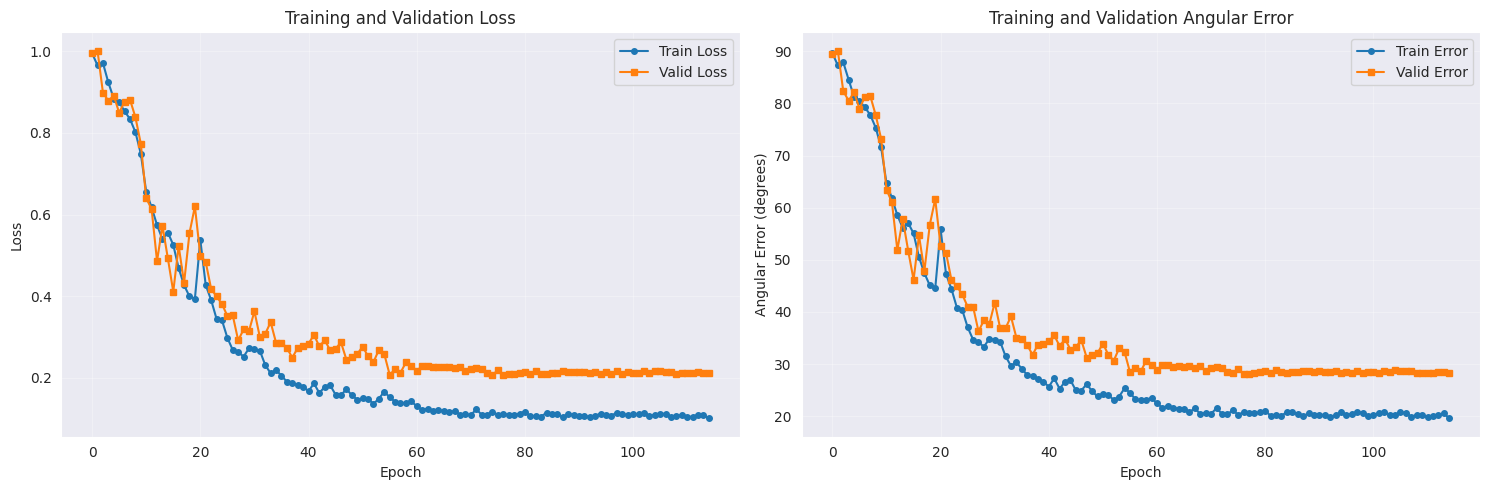

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=4)
axes[0].plot(history['valid_loss'], label='Valid Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Angular error plot
axes[1].plot(history['train_angle_error'], label='Train Error', marker='o', markersize=4)
axes[1].plot(history['valid_angle_error'], label='Valid Error', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Angular Error (degrees)')
axes[1].set_title('Training and Validation Angular Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['save_dir']) / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Load Best Model and Evaluate on Test Set

In [13]:
# Load best model
checkpoint_path = Path(CONFIG['save_dir']) / 'best_model.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Validation loss: {checkpoint['valid_loss']:.4f}")
print(f"  Validation angle error: {checkpoint['valid_angle_error']:.2f}°")

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate(model, dataloaders['test'], criterion, device)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Mean Angular Error: {test_metrics['angular_error']:.2f}°")
print(f"Median Angular Error: {np.median(test_metrics['all_errors']):.2f}°")
print(f"Std Angular Error: {np.std(test_metrics['all_errors']):.2f}°")
print(f"Max Angular Error: {np.max(test_metrics['all_errors']):.2f}°")

# Error percentiles
print("\nError Percentiles:")
for p in [25, 50, 75, 90, 95]:
    print(f"  {p}th percentile: {np.percentile(test_metrics['all_errors'], p):.2f}°")

# Accuracy at thresholds
print("\nAccuracy at different error thresholds:")
for threshold in [5, 10, 15, 20, 30, 45]:
    accuracy = (test_metrics['all_errors'] <= threshold).mean() * 100
    print(f"  Within {threshold}°: {accuracy:.2f}%")

Loaded best model from epoch 75
  Validation loss: 0.2072
  Validation angle error: 28.21°

Evaluating on test set...


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 0.2028
Mean Angular Error: 28.36°
Median Angular Error: 18.31°
Std Angular Error: 34.63°
Max Angular Error: 179.81°

Error Percentiles:
  25th percentile: 8.86°
  50th percentile: 18.31°
  75th percentile: 29.94°
  90th percentile: 57.25°
  95th percentile: 127.85°

Accuracy at different error thresholds:
  Within 5°: 15.38%
  Within 10°: 27.54%
  Within 15°: 41.94%
  Within 20°: 54.34%
  Within 30°: 75.19%
  Within 45°: 86.10%


## 14. Error Analysis

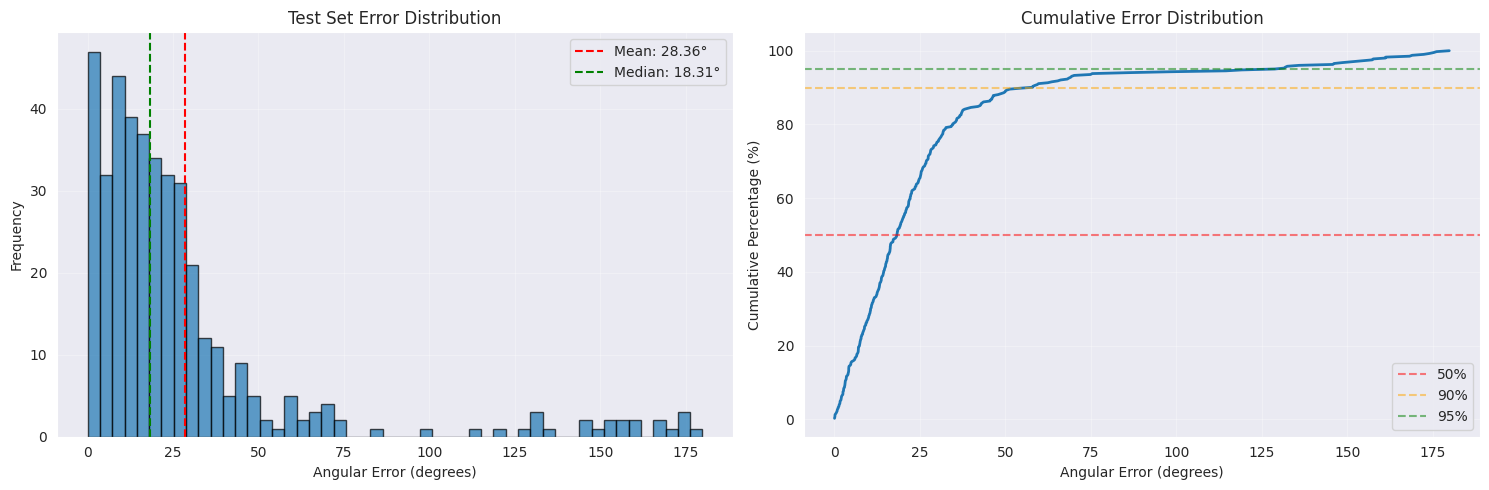

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error distribution histogram
axes[0].hist(test_metrics['all_errors'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(test_metrics['angular_error'], color='red', linestyle='--',
                label=f"Mean: {test_metrics['angular_error']:.2f}°")
axes[0].axvline(np.median(test_metrics['all_errors']), color='green', linestyle='--',
                label=f"Median: {np.median(test_metrics['all_errors']):.2f}°")
axes[0].set_xlabel('Angular Error (degrees)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Test Set Error Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_errors = np.sort(test_metrics['all_errors'])
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1].plot(sorted_errors, cumulative, linewidth=2)
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1].axhline(90, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].axhline(95, color='green', linestyle='--', alpha=0.5, label='95%')
axes[1].set_xlabel('Angular Error (degrees)')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].set_title('Cumulative Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['save_dir']) / 'error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Visualize Predictions

Visualizing predictions on test set...


/tmp/ipython-input-950720580.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_rad = np.radians(true_angles[i])
/tmp/ipython-input-950720580.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_dx = np.cos(true_rad) * 40
/tmp/ipython-input-950720580.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_dy = -np.sin(true_rad) * 40  # Negative because y-axis is inverted
/tmp/ipython-input-950720580.py:46: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pred_rad = np.radians(pred_angles[i])
/tmp/ipython-input-950720580.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (posi

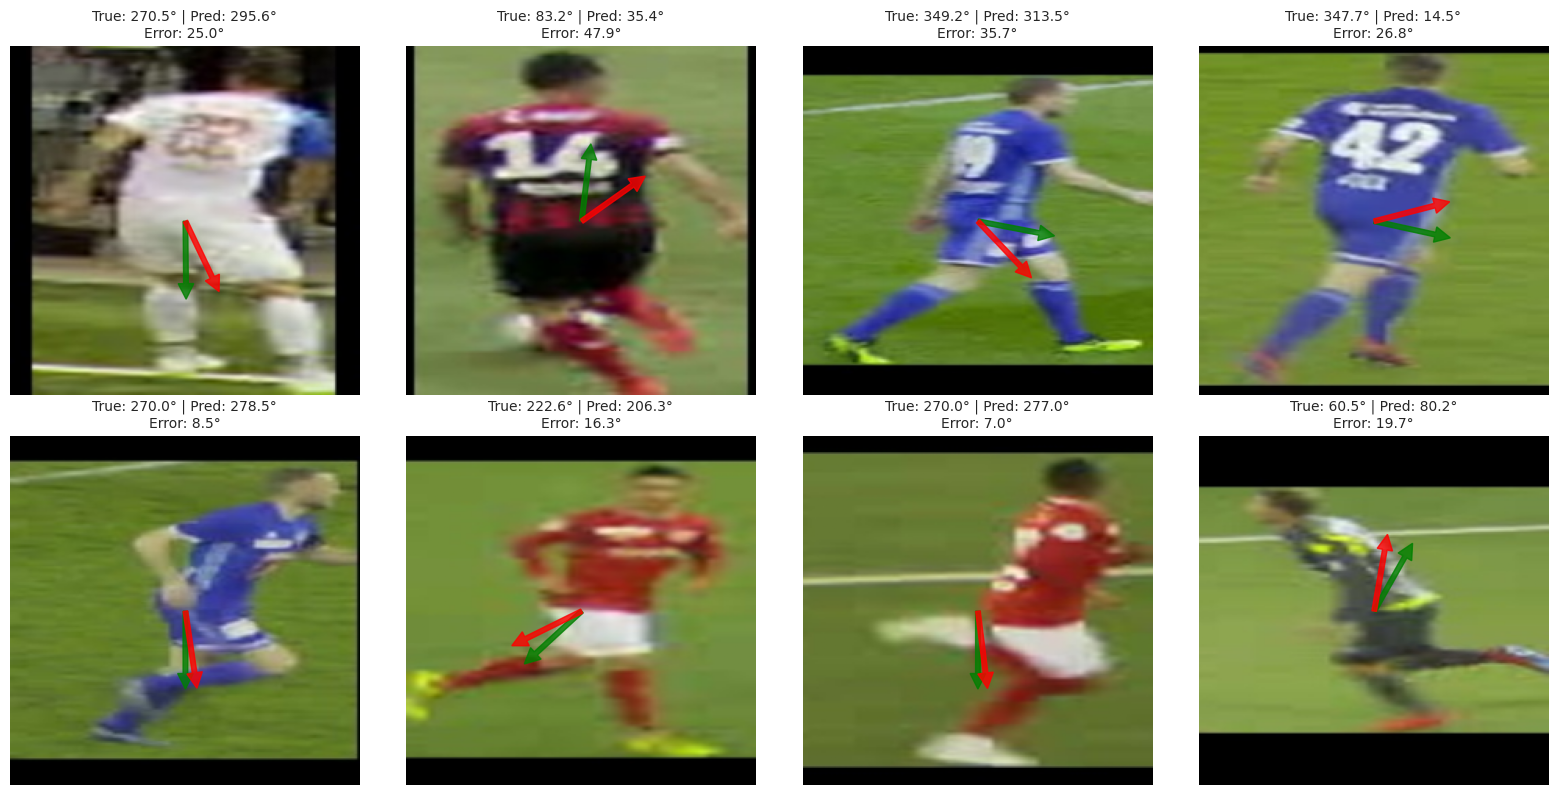

In [15]:
def visualize_predictions(model, dataloader, device, num_samples=8):
    """Visualize model predictions"""
    model.eval()

    # Get a batch
    images, bbox_pitch, directions, angles = next(iter(dataloader))

    # Predict
    with torch.no_grad():
        pred_directions = model(images.to(device), bbox_pitch.to(device))

    # Convert to angles
    pred_angles = vector_to_angle(pred_directions.cpu())
    true_angles = angles

    # Compute errors
    errors = torch.abs(pred_angles - true_angles)
    errors = torch.min(errors, 360 - errors)  # Handle wraparound

    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Plot image with arrow
        axes[i].imshow(img)

        # Draw true direction (green)
        cx, cy = img.shape[1] // 2, img.shape[0] // 2
        true_rad = np.radians(true_angles[i])
        true_dx = np.cos(true_rad) * 40
        true_dy = -np.sin(true_rad) * 40  # Negative because y-axis is inverted
        axes[i].arrow(cx, cy, true_dx, true_dy, color='green', width=3,
                     head_width=10, head_length=10, alpha=0.8, label='True')

        # Draw predicted direction (red)
        pred_rad = np.radians(pred_angles[i])
        pred_dx = np.cos(pred_rad) * 40
        pred_dy = -np.sin(pred_rad) * 40
        axes[i].arrow(cx, cy, pred_dx, pred_dy, color='red', width=3,
                     head_width=10, head_length=10, alpha=0.8, label='Pred')

        axes[i].set_title(f"True: {true_angles[i]:.1f}° | Pred: {pred_angles[i]:.1f}°\nError: {errors[i]:.1f}°",
                         fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(Path(CONFIG['save_dir']) / 'predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize
print("Visualizing predictions on test set...")
visualize_predictions(model, dataloaders['test'], device, num_samples=8)

## 16. Save Final Results

In [16]:
# Save final results
results = {
    'config': CONFIG,
    'test_metrics': {
        'loss': test_metrics['loss'],
        'mean_angular_error': test_metrics['angular_error'],
        'median_angular_error': float(np.median(test_metrics['all_errors'])),
        'std_angular_error': float(np.std(test_metrics['all_errors'])),
        'max_angular_error': float(np.max(test_metrics['all_errors'])),
    },
    'training_history': history,
    'best_epoch': checkpoint['epoch']
}

# Save to JSON
with open(Path(CONFIG['save_dir']) / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to:", Path(CONFIG['save_dir']) / 'results.json')
print("\n✓ Training complete! All artifacts saved to:", CONFIG['save_dir'])

Results saved to: /content/drive/MyDrive/player_direction_checkpoints_4059_optimized/results.json

✓ Training complete! All artifacts saved to: /content/drive/MyDrive/player_direction_checkpoints_4059_optimized
